# Linear Regression Multi Dimension + SGD Study

8-10-2018
Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loss(yt, y):
    return np.mean((yt - y)**2)/2

generate a bunch of random points

In [3]:
m = np.random.randn(2)
x = np.random.randn(2,1000) * 10
btrue = np.random.randn()
mtrue = np.random.randn(2,1)
y = mtrue.T @ x + btrue + np.random.randn(1,1000)

what is native loss?

In [4]:
m = np.random.randn(2,1)
b = 0.0
yp = m.T @ x + b
print(f"Naive loss is {loss(yp.squeeze(), y)}")

Naive loss is 218.55746143059255


In [5]:
mtrue, btrue

(array([[-0.31926985],
        [-1.78132527]]), 0.808847961458713)

## Visualize

In [6]:
x.shape

(2, 1000)

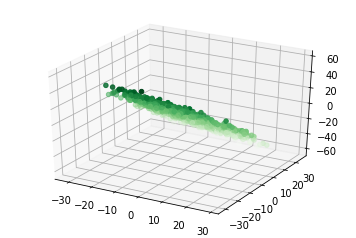

In [7]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x[0,:], x[1,:], y.squeeze(), c=y.squeeze(), cmap='Greens');


## SGD mini batch

Vectorized SGD with mini batch

In [8]:
def sgd(state, params, grads, lr=0.01):
    nps = []
    for p, dp in zip(params, grads):
        nps.append(p - lr * dp)
    return state, nps

In [9]:
def train(gradfunc, epochs = 40, bs = 100, lr = 0.01):
    w = np.random.randn(2,1)
    b = 0.0
    idxs = np.arange(x.shape[1])
    s = {}
    for e in range(epochs):
        for i in range(25):
            bs_idxs = range(i*40, i*40+40)
            x_batch = x[:, bs_idxs]
            # forward
            yh = w.T @ x_batch + b

            # back
            dyh = yh - y[:, bs_idxs]
            dw = x_batch @ dyh.T  / bs
            db = np.mean(dyh)

            s, [w,b] = gradfunc(s, [w, b], [dw, db], lr=lr)
    return w,b

In [10]:
w,b = train(sgd)
yp = w.T @ x + b
print(f"loss using SGD after 40 epochs is {loss(y, yp)}")

loss using SGD after 40 epochs is 0.5093515644702195


In [11]:
w,b

(array([[-0.31373135],
        [-1.78527277]]), 0.8146783824174163)

## Momentum method

In [12]:
def momentum(state, params, grads, lr=0.01, m=0.9):
    vs = state.get('v', list(np.zeros(len(params))))
    nvs = []
    nps = []
    for p, dp, v in zip(params, grads, vs):
        nv = m * v + lr * dp
        np_ = p - nv
        nvs.append(nv)
        nps.append(np_)
    return {'v': nvs}, nps

In [13]:
w,b = train(momentum)
yp = w.T @ x + b
print(f"loss using momentum after 40 epochs is {loss(y, yp)}")

loss using momentum after 40 epochs is 0.5778463919402147


In [14]:
w,b

(array([[-0.28568178],
        [-1.78291192]]), 0.814186878134)

## RMSProps Method

In [15]:
def rmsprop(state, params, grads, lr=0.01, b=0.9, eps=1e-8):
    es = state.get('e', list(np.zeros(len(params))))
    i = state.get('i', 1)
    nes = []
    nps = []
    #print('g',grads)
    #print(es)
    for p, g, e in zip(params, grads, es):
        ne = b * e + (1 - b) * (g**2)
        neh = ne / (1 - b**i)
        update = lr * g / (np.sqrt(neh) + eps)
        #print("update", update)
        np_ = p  - update
        nes.append(ne)
        nps.append(np_)
    return {'e': nes, 'i': i+1}, nps

In [16]:
w,b = train(rmsprop, lr=0.01)
yp = w.T @ x + b
print(f"loss using rmsprop after 40 epochs is {loss(y, yp)}")

loss using rmsprop after 40 epochs is 0.5100038734903427


In [17]:
w,b

(array([[-0.31296682],
        [-1.7843443 ]]), 0.8066572332506824)

## Adam Method

In [18]:
def adam(state, params, grads, lr=0.01, b1=0.9, b2=0.999, eps=1e-8):
    mts = state.get('mt', list(np.zeros(len(params))))
    vts = state.get('vt', list(np.zeros(len(params))))
    #print(mts, vts)
    i = state.get('i', 1)
    nmts, nvts, nps = [], [], []
    for p, g, mt, vt in zip(params, grads, mts, vts):
        nmt = (b1 * mt) + (1 - b1) * g
        nvt = (b2 * vt) + (1 - b2) * (g**2)
        mth = nmt / (1 - b1**i)
        vth = nvt / (1 - b2**i)
        update = lr * mth / (np.sqrt(vth) + eps)
        np_ = p - update
        nmts.append(nmt)
        nvts.append(nvt)
        nps.append(np_)
    #print(len(nmts), len(nvts))
    return {'i': i+1, 'mt': nmts, 'vt': nvts}, nps

In [19]:
w,b = train(adam, lr=0.01)
yp = w.T @ x + b
print(f"loss using adam after 40 epochs is {loss(y, yp)}")

loss using adam after 40 epochs is 0.5038899689128034


In [20]:
w,b

(array([[-0.32362664],
        [-1.78282085]]), 0.8174380624549208)

In [21]:
mtrue, btrue

(array([[-0.31926985],
        [-1.78132527]]), 0.808847961458713)

## Confirm with PyTorch

Check pytorch with Adam

In [22]:
import torch
from torch.nn.modules.linear import Linear
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [23]:
model = Linear(in_features=2, out_features=1)

In [24]:
epochs = 40
lr = 0.01
tx = torch.Tensor(x.T)
ty = torch.Tensor(y.T)
ds = TensorDataset(tx, ty)
dl = torch.utils.data.DataLoader(ds, batch_size=40)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [25]:
next(iter(dl))[0].shape, next(iter(dl))[1].shape

(torch.Size([40, 2]), torch.Size([40, 1]))

In [26]:
model.train()
for e in range(epochs):
    for xb, yb in dl:
        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

In [27]:
model.weight.data, model.bias.data

(tensor([[-0.3236, -1.7828]]), tensor([ 0.8176]))

In [28]:
model.eval()
with torch.no_grad():
    ylabel = model(tx)
    l = criterion(ylabel, ty)
    print(l/2)

tensor(0.5039)
